# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Write Up
Here is a link to my [writeup](https://github.com/ArjaanBuijk/CarND_Traffic_Sign_Classifier_Project/blob/master/Traffic_Sign_Classifier_writeup.md)

---
## Define all imports here

In [8]:
# define all imports here.
import pickle
import hashlib
import os
import pickle
from urllib.request import urlretrieve
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pandas as pd 
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import shuffle
import tensorflow as tf
from tqdm import tqdm
from skimage import exposure
from tensorflow.contrib.layers import flatten
import random

---
## Define hyper parameters here

In [9]:
# define hyper-parameters

# for pre-processing
myMAX_ANGLE  = 20  # Not too large ! Left direction only sign might turn into a right direction only sign and vice versa
myCLIP_LIMIT = 0.1

# for training
myEPOCHS = 200
myBATCH_SIZE = 16
myKEEP_PROB = 0.5  # dropout rate
myRATE = 0.0001    # learning rate of AdamsOptimizer


---
## Step 0: Load The Data

In [11]:
# Load pickled data

# TODO: Fill this in based on where you saved the training and testing data
folder = '/home/arjaan/data/traffic-signs-data'
training_file = folder+"/train.p"
validation_file = folder+"/valid.p"
testing_file = folder+"/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print ('Loaded data from input files')

Loaded data from input files


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [12]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

def check_and_summarize_data(X_train, y_train, 
                             X_valid, y_valid, 
                             X_test , y_test   ):  
      
    # AB: add a sanity check that data is loaded correctly
    assert(len(X_train) == len(y_train))
    assert(len(X_valid) == len(y_valid))
    assert(len(X_test) == len(y_test))
       
    # TODO: Number of training examples
    n_train = len(X_train)
       
    # AB: Number of validation examples
    n_valid = len(X_valid)
       
    # TODO: Number of testing examples.
    n_test = len(X_test)
       
    # TODO: What's the shape of an traffic sign image?
    image_shape = X_train[0].shape
       
    # TODO: How many unique classes/labels there are in the dataset.
    unique_train = set(y_train)
    unique_valid = set(y_valid)
    unique_test  = set(y_test)
    unique_all   = set( np.concatenate((y_train, y_valid, y_test)) )
    #
    n_classes_train = len(unique_train)
    n_classes_valid = len(unique_valid)
    n_classes_test  = len(unique_test)
    n_classes       = len(unique_all)
       
    print("Number of training examples =", n_train)
    print("Number of validation examples =", n_valid)
    print("Number of testing examples =", n_test)
    print("Image data shape =", image_shape)
    print("Number of unique classes in training examples =", n_classes_train)
    print("Number of unique classes in validation examples =", n_classes_valid)
    print("Number of unique classes in testing examples =", n_classes_test)
    print("Number of unique classes in all =", n_classes)


In [13]:
check_and_summarize_data(X_train, y_train, 
                         X_valid, y_valid, 
                         X_test , y_test   )       

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of unique classes in training examples = 43
Number of unique classes in validation examples = 43
Number of unique classes in testing examples = 43
Number of unique classes in all = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [14]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.

# Visualizations will be shown in the notebook.
%matplotlib inline

# read sign labels into a panda DataFrame
df = pd.read_csv('signnames.csv')


# View sample from the unique datasets -> show an image of each class
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   
    
def apply_clahe(img, clip_limit=0.01):
    """Applies a Contrast Limited Adaptive Histogram Equalization (CLAHE)
    for description:
    http://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_adapthist
    """
    return exposure.equalize_adapthist(img, clip_limit=clip_limit)
      
def plot_image_and_effects_of_grayscale_and_clahe(X_data,y_data,
                                                  filename=None):
    """
    Plots a table showing the effects of gray scale, and also the application
    of a Contrast Limited Adaptive Histogram Equalization (CLAHE)
    
    label  |  RGB image   | Gray Scale image | CLAHE
    """
    class_counts = {}
    for y in y_data:
        class_counts[y] = class_counts.get(y,0) + 1
    
    nrows       = len(set(y_data)) + 1
    ncols       = 4            
    axes_width  = 4            
    axes_height = 1            
    width       = ncols * axes_width    
    height      = nrows * axes_height  
    fontsize    = 10  
    fig, axes   = plt.subplots(nrows, ncols, figsize = (width, height) )
          
    # turn off:
    #  - all tick marks and tick labels
    #  - frame of each axes
    for row in range(nrows):
        for ncol in range(ncols):
            axes[row,ncol].xaxis.set_visible(False)
            axes[row,ncol].yaxis.set_visible(False)
            axes[row,ncol].set_frame_on(False)
          
          
    # Header of columns
    row = 0
    axes[row, 0].text(0.0, 0.25, 
                      'Class',
                      fontsize=fontsize)
    axes[row, 1].text(0.4, 0.25, 
                      'RGB Image',
                      fontsize=fontsize)
    axes[row, 2].text(0.4, 0.25, 
                      'GrayScale Image',
                      fontsize=fontsize)
    axes[row, 3].text(0.4, 0.25, 
                      'CLAHE Image',
                      fontsize=fontsize)
              
    class_shown = []
    row = 1
    for i in y_data.argsort(): # sort images by class label
        x, y = X_data[i], y_data[i]
        if y in class_shown:     # We already showed an image of this class
            continue
              
        image = x.squeeze()
        gray  = grayscale(image)
        clahe = apply_clahe(gray, clip_limit=myCLIP_LIMIT)  # yet another hyperparameter !!
              
        # show color & grayscale & clahe side by side
              
        # See this for all details on the methods used:
        # http://matplotlib.org/api/axes_api.html
              
        # class label and description stored in first column
        # with counts
        axes[row, 0].text(0.0, 0.25, 
                        ('class =' + str(y) + ': ' +  df.loc[y]['SignName'] +'\n' +
                         'count in training set: ' + str(class_counts[y]) ),
                        fontsize=fontsize)
              
        axes[row,1].imshow(image)
        axes[row,2].imshow(gray, cmap="gray")
        axes[row,3].imshow(clahe, cmap="gray")
              
        class_shown.append(y)
        row += 1
    
    if filename == None:      
        plt.show()  
    else:  
        # When running python directly, not in Jupyter notebook, it is better to
        # write it to a file & view it in an image viewer
        fig.savefig(filename)
        print ('Written the file: '+ filename)
          
    plt.close(fig)
    
# Plot a histogram showing the distribution inside both the training and
# testing set.
def histogram_of_data_set_distributions(y_train, y_test):
    """
    Creates a histogram where for each class the number of entries in the
    training and test set are shown.
    """
    unique_classes = np.array(list(set(y_train)))
    num_classes = len(unique_classes)
    bar_names      = []
    for i in unique_classes.argsort(): # sort images by class label
        y = unique_classes[i]
        bar_names.append('class =' + str(y) + ': ' +  df.loc[y]['SignName'])
    
    nrows       = 1
    ncols       = 1            
    axes_width  = 12           
    axes_height = 3            
    width       = ncols * axes_width    
    height      = nrows * axes_height   
    fig, axes   = plt.subplots(nrows, ncols, figsize = (width, height) )
    
    # number of bins for the histogram
    # add one extra, and then left-align the histogram
    # - the extra bin will be empty  (do not plot a tick for it...)
    # - the ticks will be centered to the bars drawn.
    bins= np.arange(num_classes+1)
 
    hist1 = axes.hist(y_train, bins, align='left', 
                      color='b', edgecolor='black', label='training data')
    hist2 = axes.hist(y_test, bins, align='left', 
                      color='g', edgecolor='black', label='test data')

    # add x,y axis labels & title 
    axes.set_xlabel("Class ID")
    axes.set_ylabel("Number of images per class")
    axes.set_title("Training and Test Data Distribution Histogram")
    
    # define ticks
    # set xticks ids to 0,1,....42  
    # -> omit tick for bin 43
    axes.set_xticks(bins[:-1]) 
    plt.xticks(axes.get_xticks(), fontsize = 6)
    
    # show the legend
    axes.legend()

    plt.show()


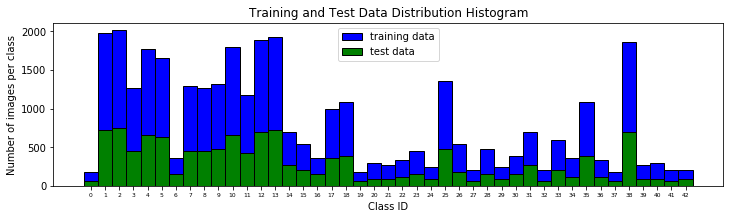

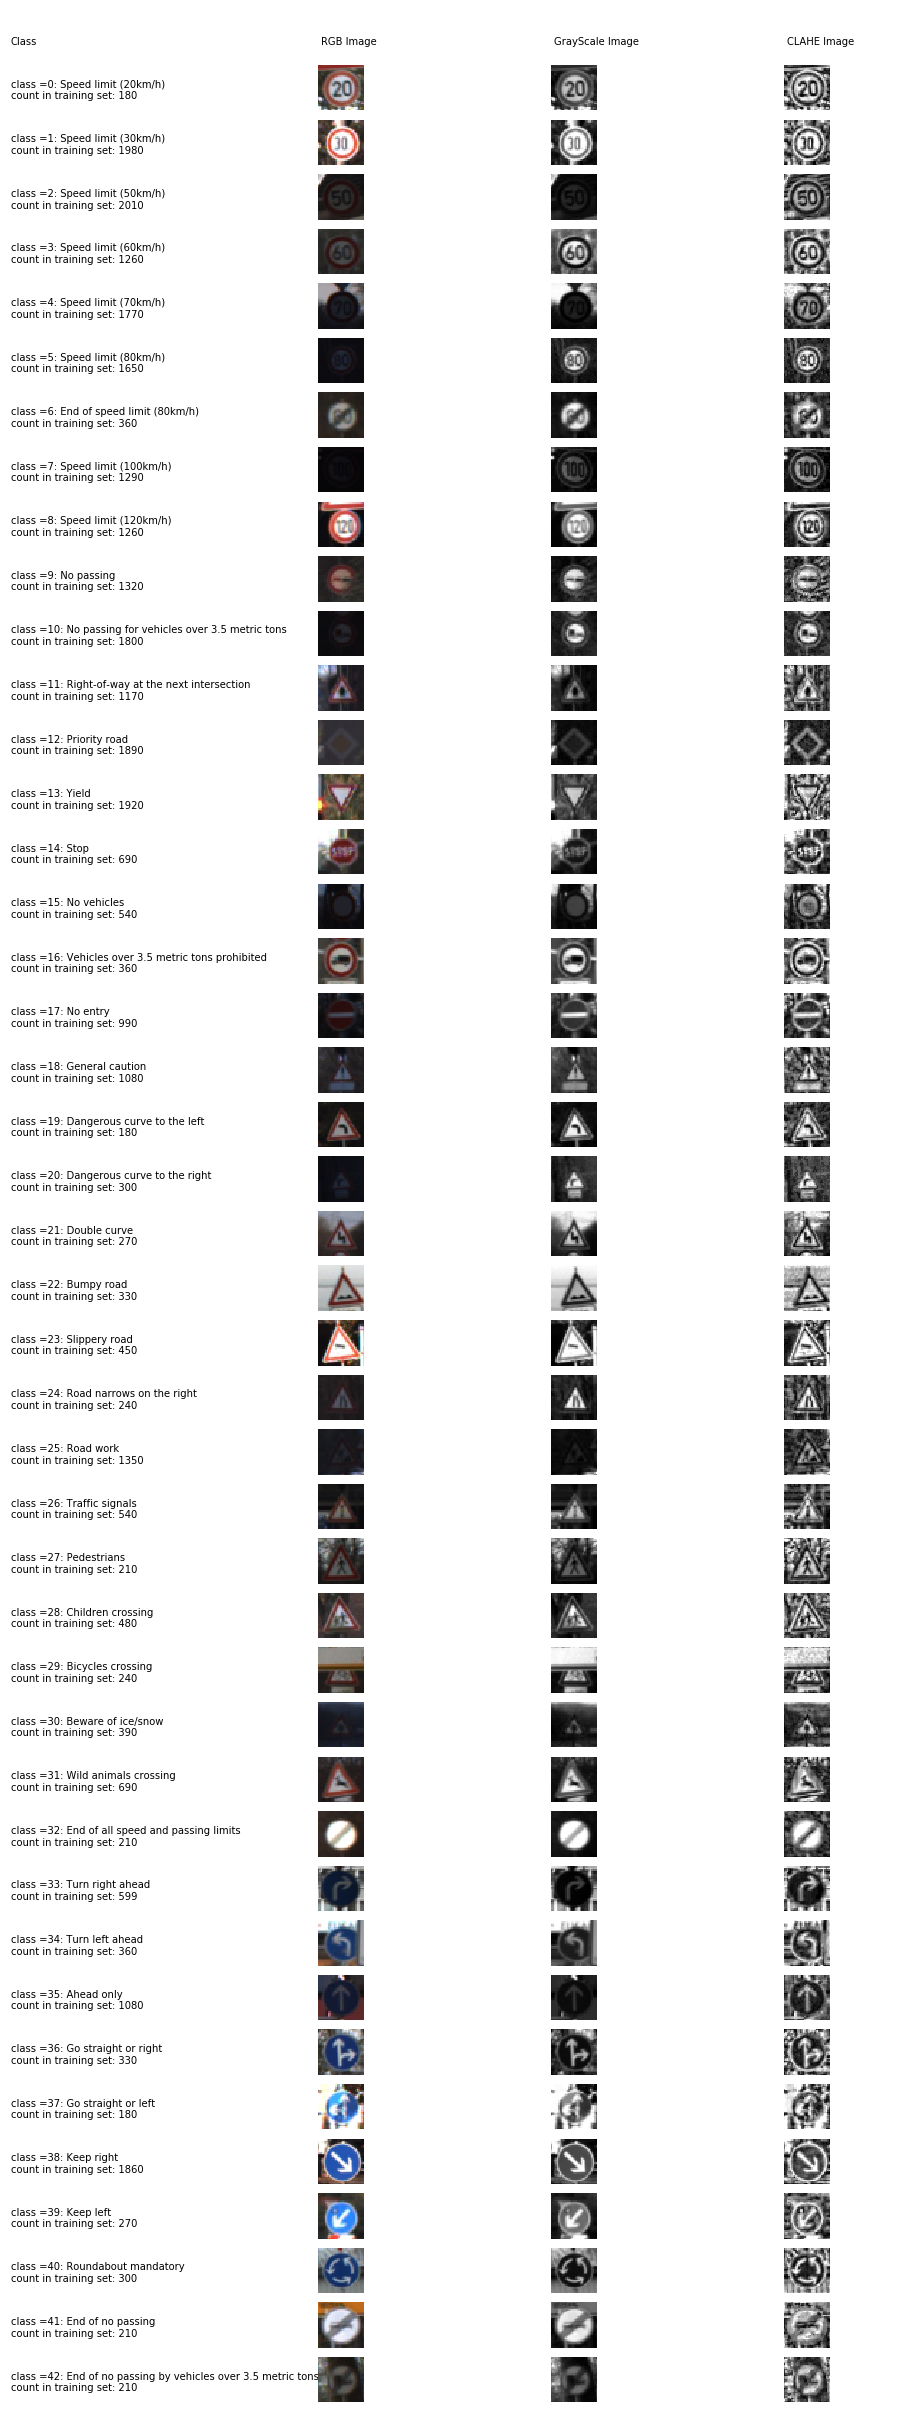

In [15]:
histogram_of_data_set_distributions(y_train, y_test)
plot_image_and_effects_of_grayscale_and_clahe(X_train,y_train,
                                              filename=None)


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

## Augment the data

The investigation shows there is an uneven distribution among the classes.
This is addressed by augmenting the data, using a random rotation.
We add new images for those classes that have less than the max count.

In [16]:
def rotate_image(img, max_angle=myMAX_ANGLE):
    """
    see: http://docs.opencv.org/trunk/da/d6e/tutorial_py_geometric_transformations.html
    randomly transforms an image by rotation.   
    """
    rows, cols, _ = img.shape
    angle = random.uniform(-max_angle, max_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    return cv2.warpAffine(img,M,(cols,rows))

def augment_training_data(X_train,y_train):
    """
    Augment training data so that each class has same number of images
    """
    class_counts = {}
    for y in y_train:
        class_counts[y] = class_counts.get(y,0) + 1
        
    max_class_count = max([class_counts[k] for k in class_counts])
    
    X_train_orig = np.copy(X_train)
    y_train_orig = np.copy(y_train)
    
    class_has_been_augmented = {}
    X_train = list(X_train) # do augmentation by python list appending (FAST!)
    y_train = list(y_train)
    for i in y_train_orig.argsort(): # sort images by class label
        x, y = X_train_orig[i], y_train_orig[i]
        if class_has_been_augmented.get(y,False):
            continue
            
        images_to_add = max_class_count - class_counts[y]
        
        if images_to_add > 0:
            print('Augmenting class '+str(y)+' with '+str(images_to_add)+' images...')
            images_added = 0
            i_start = i
            ii = i
            for j in tqdm(range(images_to_add)):
                x, y = X_train_orig[ii], y_train_orig[ii]
                #image = x.squeeze()
                new_image = rotate_image(x,max_angle=myMAX_ANGLE)
                X_train.append(new_image.reshape(32,32,3)) 
                y_train.append(y)

                images_added += 1
                ii += 1
                if y_train_orig[ii] != y: # next label, so 'rewind'
                    ii = i_start
                    
        class_has_been_augmented[y] = True
    
    # convert python list back to numpy arrays with correct shape
    X_train = np.array(X_train).reshape(len(y_train),32,32,3)
    y_train = np.array(y_train)
        
    return X_train, y_train


In [17]:
X_train, y_train = augment_training_data(X_train, y_train)

  0%|          | 0/840 [00:00<?, ?it/s]

Augmenting class 0 with 1830 images...
Augmenting class 1 with 30 images...
Augmenting class 3 with 750 images...
Augmenting class 4 with 240 images...
Augmenting class 5 with 360 images...
Augmenting class 6 with 1650 images...
Augmenting class 7 with 720 images...
Augmenting class 8 with 750 images...
Augmenting class 9 with 690 images...
Augmenting class 10 with 210 images...
Augmenting class 11 with 840 images...


  0%|          | 0/1710 [00:00<?, ?it/s]

Augmenting class 12 with 120 images...
Augmenting class 13 with 90 images...
Augmenting class 14 with 1320 images...
Augmenting class 15 with 1470 images...
Augmenting class 16 with 1650 images...
Augmenting class 17 with 1020 images...
Augmenting class 18 with 930 images...
Augmenting class 19 with 1830 images...
Augmenting class 20 with 1710 images...


  0%|          | 0/1800 [00:00<?, ?it/s]

Augmenting class 21 with 1740 images...
Augmenting class 22 with 1680 images...
Augmenting class 23 with 1560 images...
Augmenting class 24 with 1770 images...
Augmenting class 25 with 660 images...
Augmenting class 26 with 1470 images...
Augmenting class 27 with 1800 images...


  0%|          | 0/1650 [00:00<?, ?it/s]

Augmenting class 28 with 1530 images...
Augmenting class 29 with 1770 images...
Augmenting class 30 with 1620 images...
Augmenting class 31 with 1320 images...
Augmenting class 32 with 1800 images...
Augmenting class 33 with 1411 images...
Augmenting class 34 with 1650 images...


  0%|          | 0/1800 [00:00<?, ?it/s]

Augmenting class 35 with 930 images...
Augmenting class 36 with 1680 images...
Augmenting class 37 with 1830 images...
Augmenting class 38 with 150 images...
Augmenting class 39 with 1740 images...
Augmenting class 40 with 1710 images...
Augmenting class 41 with 1800 images...


100%|██████████| 1800/1800 [00:00<00:00, 47753.89it/s]


Augmenting class 42 with 1800 images...


### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [18]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.

def grayscale_and_clahe(image_data):
    """
    Convert the image data to grayscale, then clahe
    NOTE: CLAHE image is normalized.
    :param image_data: The image data to be converted & normalized
    :return: Grayscaled and CLAHEd image
    """  
    gray  = grayscale(image_data)
    clahe = apply_clahe(gray, clip_limit=myCLIP_LIMIT)  # yet another hyperparameter !!
    return clahe

In [19]:
print('Applying GrayScale & CLAHE to each image in train data set')
train_features = np.array([grayscale_and_clahe(x) for x in tqdm(X_train)])

print('Applying GrayScale & CLAHE to each image in validation data set')
valid_features = np.array([grayscale_and_clahe(x) for x in tqdm(X_valid)])

print('Applying GrayScale & CLAHE to each image in test data set')
test_features  = np.array([grayscale_and_clahe(x) for x in tqdm(X_test)])

train_labels = y_train
valid_labels = y_valid
test_labels  = y_test
is_features_normal = True

# Save the data for easy access
pickle_file = 'signs_prepped.pickle'
#if not os.path.isfile(pickle_file): #..always just overwrite !

try:
    with open(pickle_file, 'wb') as pfile:
        pickle.dump(
            {
                'train_dataset': train_features,
                'train_labels': train_labels,
                'valid_dataset': valid_features,
                'valid_labels': valid_labels,
                'test_dataset': test_features,
                'test_labels': test_labels,
            },
            pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
      
print('Data cached in pickle file: '+str(pickle_file))

  0%|          | 11/86430 [00:00<13:41, 105.25it/s]

Applying GrayScale & CLAHE to each image in train data set


  0%|          | 11/4410 [00:00<00:41, 107.19it/s]

Applying GrayScale & CLAHE to each image in validation data set


  0%|          | 12/12630 [00:00<01:52, 112.36it/s]

Applying GrayScale & CLAHE to each image in test data set


100%|██████████| 12630/12630 [01:58<00:00, 106.78it/s]


Data cached in pickle file: signs_prepped.pickle


### Model Architecture

In [20]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
"""
The LeNet-5 implementation with one addition:
A dropout is added prior to the readout layer
"""
def LeNet(x_input):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x_input, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1_r = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1_p = tf.nn.max_pool(conv1_r, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1_p, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2_r = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2_p = tf.nn.max_pool(conv2_r, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2_p)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1_r    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1_r, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2_r    = tf.nn.relu(fc2)
    
    #ab: add a dropout layer
    #see: https://www.tensorflow.org/get_started/mnist/pros
    fc2_drop = tf.nn.dropout(fc2_r, keep_prob) 

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    # Output of this final layer must be equal to the number of classes !
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2_drop, fc3_W) + fc3_b
    
    return conv1, conv2, fc1, fc2, logits  # return all layers, to allow visualization


In [21]:
"""
Features and Labels:
- x_input is a placeholder for a batch of input images. 
- y_input is a placeholder for a batch of output labels.
- keep_prob is a placeholder for dropout (0.5 during training, 1.0 during test)
"""
x_input = tf.placeholder(tf.float32, (None, 32, 32, 1))  # 1 for GrayScale
y_input = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)

one_hot_y = tf.one_hot(y_input, 43) # 43 classes !


In [23]:
"""
Training Pipeline
Create a training pipeline that uses the model to classify the data.
"""

conv1, conv2, fc1, fc2, logits = LeNet(x_input) # receiving back all layers, to allow visualization
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=myRATE)
training_operation = optimizer.minimize(loss_operation)


In [24]:
"""
Function to evaluate the accuracy of the model for a given dataset.
"""
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, myBATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+myBATCH_SIZE], y_data[offset:offset+myBATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={
          x_input: batch_x, y_input: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [25]:
"""
Functions to summarize the predictions for a given dataset.
"""
def prediction_counts(labels, predictions):  
    count_labels         = {}
    count_true_positive  = {}
    count_false_positive = {}
    count_false_negative = {}
    
    for y, p in zip(labels, predictions):
        count_labels[y] = count_labels.get(y,0) + 1
        if p == y:
            count_true_positive[y] = count_true_positive.get(y,0) + 1
        else:
            count_false_positive[p] = count_false_positive.get(p,0) + 1
            count_false_negative[y] = count_false_negative.get(y,0) + 1
            
    return (count_labels, 
            count_true_positive, count_false_positive, count_false_negative)  

def summarize_predictions(X_data,y_data, predictions,
                          filename=None):        
    count_labels, count_true_positive, \
    count_false_positive, count_false_negative =\
    prediction_counts(y_data, predictions)
              
    print("Prediction summary: ")
    print("{0:<60}{1:>8}{2:>12}{3:>12}{4:>10}".
          format("label", "count","true-pos","false-neg","false-pos"))
    
    total_v    = 0
    total_v_tp = 0
    total_v_fp = 0
    total_v_fn = 0
    total_v_fn_to_plot = 0
    for label in np.sort(list(set(y_data))): 
        v    = count_labels.get(label,0)
        v_tp = count_true_positive.get(label,0)
        v_fp = count_false_positive.get(label,0)
        v_fn = count_false_negative.get(label,0)
        
        total_v    += v   
        total_v_tp += v_tp
        total_v_fp += v_fp
        total_v_fn += v_fn
        total_v_fn_to_plot += min(2, v_fn) # we plot only 2 max per class
         
        # %-ages correct and wrong
        v_tp_p = int(v_tp/v*100.0)
        v_fn_p = int(v_fn/v*100.0)
        
        # pack label & description
        s_label = 'class =' + str(label) + ': ' +  df.loc[label]['SignName']
         
        # pack it like: 1966(99%)
        s_pack = "{0:5d}({1:<3d}%)"
        s_v_tp = s_pack.format(v_tp, v_tp_p)
        s_v_fn = s_pack.format(v_fn, v_fn_p)
        print("{0:<60}{1:>8d}{2:>12}{3:>12}{4:>10d}".
              format(s_label, v, s_v_tp, s_v_fn, v_fp) )
    
    separator = '-'*(60+8+12+12+10)
    print(separator )
    print("{0:<60}{1:>8d}{2:>12}{3:>12}{4:>10d}".
              format('TOTAL', total_v, total_v_tp, total_v_fn, total_v_fp) )
    
    #
    # plot false-negatives, if there are any
    #
    if total_v_fn_to_plot > 0:
        print("Plotting some of the false negatives...")
        # plot a max of 2 false-negative per class, just to get an idea...
        max_per_class = 2

        nrows       = 1 + total_v_fn_to_plot

        ncols       = 2            # label  |  Gray Scale image
        axes_width  = 6            
        axes_height = 1            
        width       = ncols * axes_width    
        height      = nrows * axes_height  
        fontsize    = 15  
        fig, axes   = plt.subplots(nrows, ncols, figsize = (width, height) )

        # turn off:
        #  - all tick marks and tick labels
        #  - frame of each axes
        for row in range(nrows):
            for ncol in range(ncols):
                axes[row,ncol].xaxis.set_visible(False)
                axes[row,ncol].yaxis.set_visible(False)
                axes[row,ncol].set_frame_on(False)


        # Header of columns
        row = 0
        axes[row, 0].text(0.0, 0.25, 
                          'Class',
                          fontsize=fontsize)
        axes[row, 1].text(0.4, 0.25, 
                          'Image of False Negative Prediction',
                          fontsize=fontsize)

        row = 1
        plotted = {}
        for i in tqdm(y_data.argsort()): # sort images by class label   
            x, y, p = X_data[i], y_data[i], predictions[i]

            if plotted.get(y,0) == max_per_class:
                continue

            if p != y:
                # false negative for y

                plotted[y] = plotted.get(y,0) + 1

                image = x.squeeze()

                axes[row, 0].text(0.0, 0.25, 
                                ('class     =' + str(y) + ': ' +  df.loc[y]['SignName'] + '\n' +
                                 'predicted =' + str(p) + ': ' +  df.loc[p]['SignName']),
                                fontsize=fontsize)

                axes[row,1].imshow(image, cmap="gray")

                row += 1

        if filename == None:      
            plt.show()  
        else:  
            # When running python directly, not in Jupyter notebook, it is better to
            # write it to a file & view it in an image viewer
            fig.savefig(filename)
            print ('Written the file: '+ filename)

        plt.close(fig)
        
def summarize_top_probabilities(y_data, TopKV2, filename=None): 
    print("Top 5 softmax probabilities")
    
    for label, softmax, indices in zip(y_data,
                                       TopKV2.values,
                                       TopKV2.indices): 
        print('-'*80)
        # pack label & description
        s_label = 'class =' + str(label) + ': ' +  df.loc[label]['SignName']
        print(s_label)
        
        s_indices=[]
        s_softmax=[]
        for ii,ss in zip(indices, softmax):
            s_indices.append('{:>10}'.format(ii))
            sss = '{:.2f}%'.format(ss*100)
            s_softmax.append('{:>10}'.format(sss))
        
        # print them
        print('Predictions   :'+str(s_indices))
        print('Probabilities :'+str(s_softmax))
        
        # also barplot them
        nrows       = 1 
        ncols       = 1         
        axes_width  = 10            
        axes_height = 4            
        width       = ncols * axes_width    
        height      = nrows * axes_height  
        fontsize    = 15  
        fig, axes   = plt.subplots(nrows, ncols, figsize = (width, height) )

        ind = range(len(indices))
        axes.bar(ind, softmax*100, color='b')  
        axes.set_xlabel('Class IDs of Top 5 softmax predictions')
        axes.set_ylabel('softmax probability')
        axes.set_xticks(ind)
        axes.set_xticklabels([str(pred) for pred in indices ])

        if filename == None:      
            plt.show()  
        else:  
            # When running python directly, not in Jupyter notebook, it is better to
            # write it to a file & view it in an image viewer
            fig.savefig(filename)
            print ('Written the file: '+ filename)

        plt.close(fig)
    
 
def plot_accuracies_vs_epochs(accuracy_train, accuracy_valid, filename=None):
    nrows       = 1 
    ncols       = 1         
    axes_width  = 10            
    axes_height = 4            
    width       = ncols * axes_width    
    height      = nrows * axes_height  
    fontsize    = 15  
    fig, axes   = plt.subplots(nrows, ncols, figsize = (width, height) )

    epochs = range(len(accuracy_train))
    axes.plot(epochs, accuracy_train, color='b', label='Training Accuracy')
    axes.plot(epochs, accuracy_valid, color='r', label='Validation Accuracy')
    
    axes.legend()

    if filename == None:      
        plt.show()  
    else:  
        # When running python directly, not in Jupyter notebook, it is better to
        # write it to a file & view it in an image viewer
        fig.savefig(filename)
        print ('Written the file: '+ filename)

    plt.close(fig)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

## Load the pre-processed data

In [26]:
"""
Load the pre-processed data from the pickle file
"""
pickle_file = 'signs_prepped.pickle'
with open(pickle_file, 'rb') as f:
    pickle_data    = pickle.load(f)
    train_features = pickle_data['train_dataset']
    train_labels   = pickle_data['train_labels']
    valid_features = pickle_data['valid_dataset']
    valid_labels   = pickle_data['valid_labels']
    test_features  = pickle_data['test_dataset']
    test_labels    = pickle_data['test_labels']
    del pickle_data  # Free up memory

# reshape features in proper format (N,32,32,1)
X_train = train_features.reshape(len(train_features), 32, 32, 1)
y_train = train_labels  
X_valid = valid_features.reshape(len(valid_features), 32, 32, 1)
y_valid = valid_labels  
X_test  = test_features.reshape(len(test_features), 32, 32, 1) 
y_test  = test_labels   

print('Data and modules loaded from pickle file.')
check_and_summarize_data(X_train, y_train, 
                         X_valid, y_valid, 
                         X_test , y_test   )  

Data and modules loaded from pickle file.
Number of training examples = 86430
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 1)
Number of unique classes in training examples = 43
Number of unique classes in validation examples = 43
Number of unique classes in testing examples = 43
Number of unique classes in all = 43


### Train the Model

In [27]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

"""
Train the model on the training data, 
Validate accuracy on the validation data.
"""
print("Training with hyper-parameters:")
print("MAX_ANGLE  = "+str(myMAX_ANGLE))
print("CLIP_LIMIT = "+str(myCLIP_LIMIT))
print("EPOCHS     = "+str(myEPOCHS))
print("BATCH_SIZE = "+str(myBATCH_SIZE))
print("KEEP_PROB  = "+str(myKEEP_PROB))
print("RATE       = "+str(myRATE))
#print("EPSILON    = "+str(EPSILON))
print()

# store accuracies for plotting
accuracy_train = []
accuracy_valid = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
       

    for i in range(myEPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        
        for offset in range(0, num_examples, myBATCH_SIZE):
            end = offset + myBATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={
                        x_input: batch_x, y_input: batch_y, keep_prob: myKEEP_PROB})
               
        accuracy_train.append(evaluate(X_train, y_train))
        accuracy_valid.append(evaluate(X_valid, y_valid))
        print("EPOCH {0:<12d}: Training, Validation Accuracies:{1:.3f}, {2:.3f}".format(i+1,
                                                                                        accuracy_train[i],
                                                                                        accuracy_valid[i]))
        
        # save the model every now & then
        if i % 50 == 0 or i == myEPOCHS-1:  
            saver.save(sess, './lenet')
            print("Trained model saved")
    


Training with hyper-parameters:
MAX_ANGLE  = 20
CLIP_LIMIT = 0.1
EPOCHS     = 200
BATCH_SIZE = 16
KEEP_PROB  = 0.5
RATE       = 0.0001

EPOCH 1           : Training, Validation Accuracies:0.806, 0.759
Trained model saved
EPOCH 2           : Training, Validation Accuracies:0.885, 0.829
EPOCH 3           : Training, Validation Accuracies:0.923, 0.880
EPOCH 4           : Training, Validation Accuracies:0.945, 0.904
EPOCH 5           : Training, Validation Accuracies:0.959, 0.929
EPOCH 6           : Training, Validation Accuracies:0.966, 0.934
EPOCH 7           : Training, Validation Accuracies:0.972, 0.935
EPOCH 8           : Training, Validation Accuracies:0.977, 0.944
EPOCH 9           : Training, Validation Accuracies:0.981, 0.945
EPOCH 10          : Training, Validation Accuracies:0.983, 0.948
EPOCH 11          : Training, Validation Accuracies:0.985, 0.949
EPOCH 12          : Training, Validation Accuracies:0.986, 0.949
EPOCH 13          : Training, Validation Accuracies:0.987, 0.951

KeyboardInterrupt: 

### Plot training and validation accuracy vs Epochs

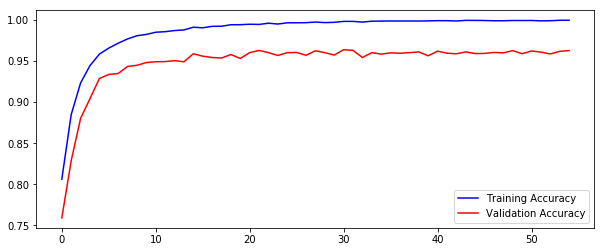

In [28]:
"""
Plot of accuracies for training & validation as function of EPOCHs
"""    
plot_accuracies_vs_epochs(accuracy_train, accuracy_valid)

### Summarize training accuracy & prediction

INFO:tensorflow:Restoring parameters from ./lenet
Training accuracy and summary of predictions
Training Accuracy   = 1.000
Prediction summary: 
label                                                          count    true-pos   false-neg false-pos
class =0: Speed limit (20km/h)                                  2010  2010(100%)     0(0  %)         1
class =1: Speed limit (30km/h)                                  2010  2009(99 %)     1(0  %)         6
class =2: Speed limit (50km/h)                                  2010  2002(99 %)     8(0  %)         1
class =3: Speed limit (60km/h)                                  2010  2003(99 %)     7(0  %)         1
class =4: Speed limit (70km/h)                                  2010  2005(99 %)     5(0  %)         0
class =5: Speed limit (80km/h)                                  2010  2009(99 %)     1(0  %)        17
class =6: End of speed limit (80km/h)                           2010  2010(100%)     0(0  %)         0
class =7: Speed limit (100km/h) 

100%|██████████| 86430/86430 [00:00<00:00, 668134.41it/s]


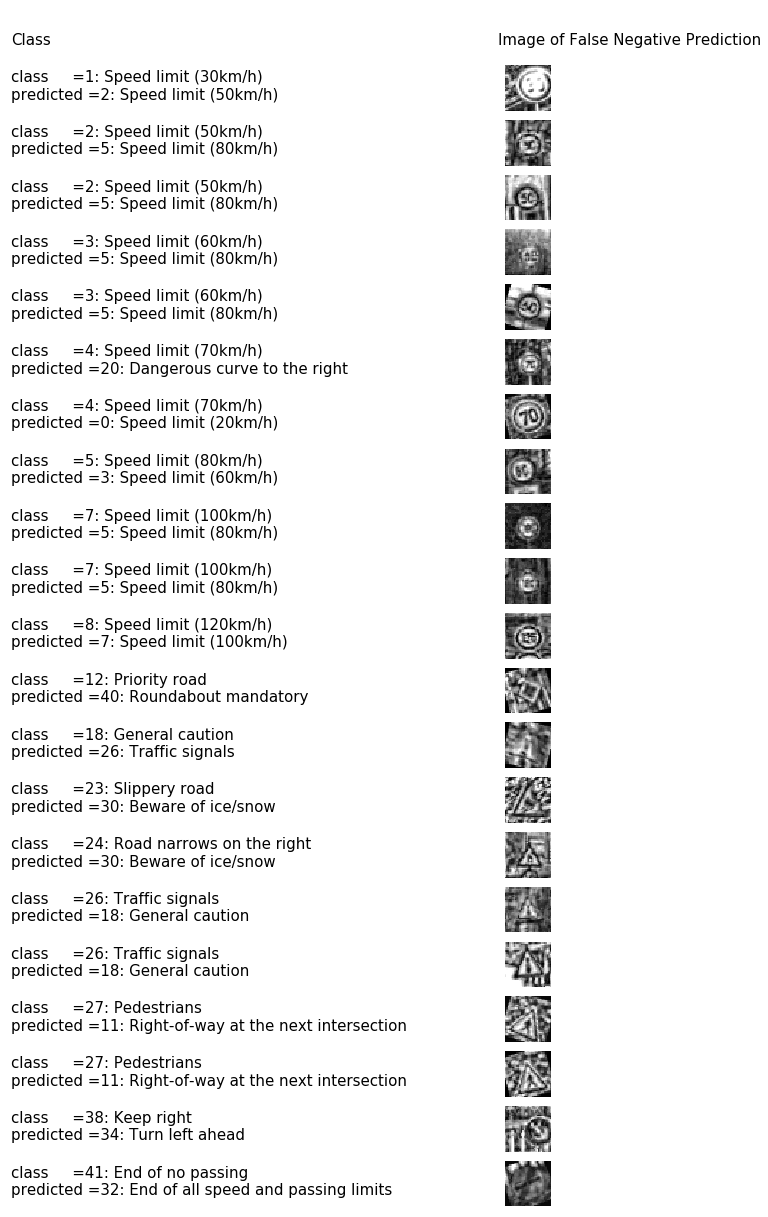

In [29]:
"""
Summary of training accuracies & predictions
"""
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    print ('Training accuracy and summary of predictions')
    accuracy = evaluate(X_train, y_train)
    print("Training Accuracy   = {:.3f}".format(accuracy))
    predictions = sess.run(tf.argmax(logits, 1), 
                               feed_dict={x_input:X_train, keep_prob:1.0})
    summarize_predictions(X_train, y_train, predictions, filename=None)

### Summarize validation accuracy & prediction

INFO:tensorflow:Restoring parameters from ./lenet
Validation accuracy and summary of predictions
Validation Accuracy = 0.962
Prediction summary: 
label                                                          count    true-pos   false-neg false-pos
class =0: Speed limit (20km/h)                                    30    23(76 %)     7(23 %)         0
class =1: Speed limit (30km/h)                                   240   232(96 %)     8(3  %)        12
class =2: Speed limit (50km/h)                                   240   228(95 %)    12(5  %)         9
class =3: Speed limit (60km/h)                                   150   140(93 %)    10(6  %)         6
class =4: Speed limit (70km/h)                                   210   208(99 %)     2(0  %)         3
class =5: Speed limit (80km/h)                                   210   204(97 %)     6(2  %)        25
class =6: End of speed limit (80km/h)                             60    59(98 %)     1(1  %)         0
class =7: Speed limit (100km/h

100%|██████████| 4410/4410 [00:00<00:00, 81348.24it/s]


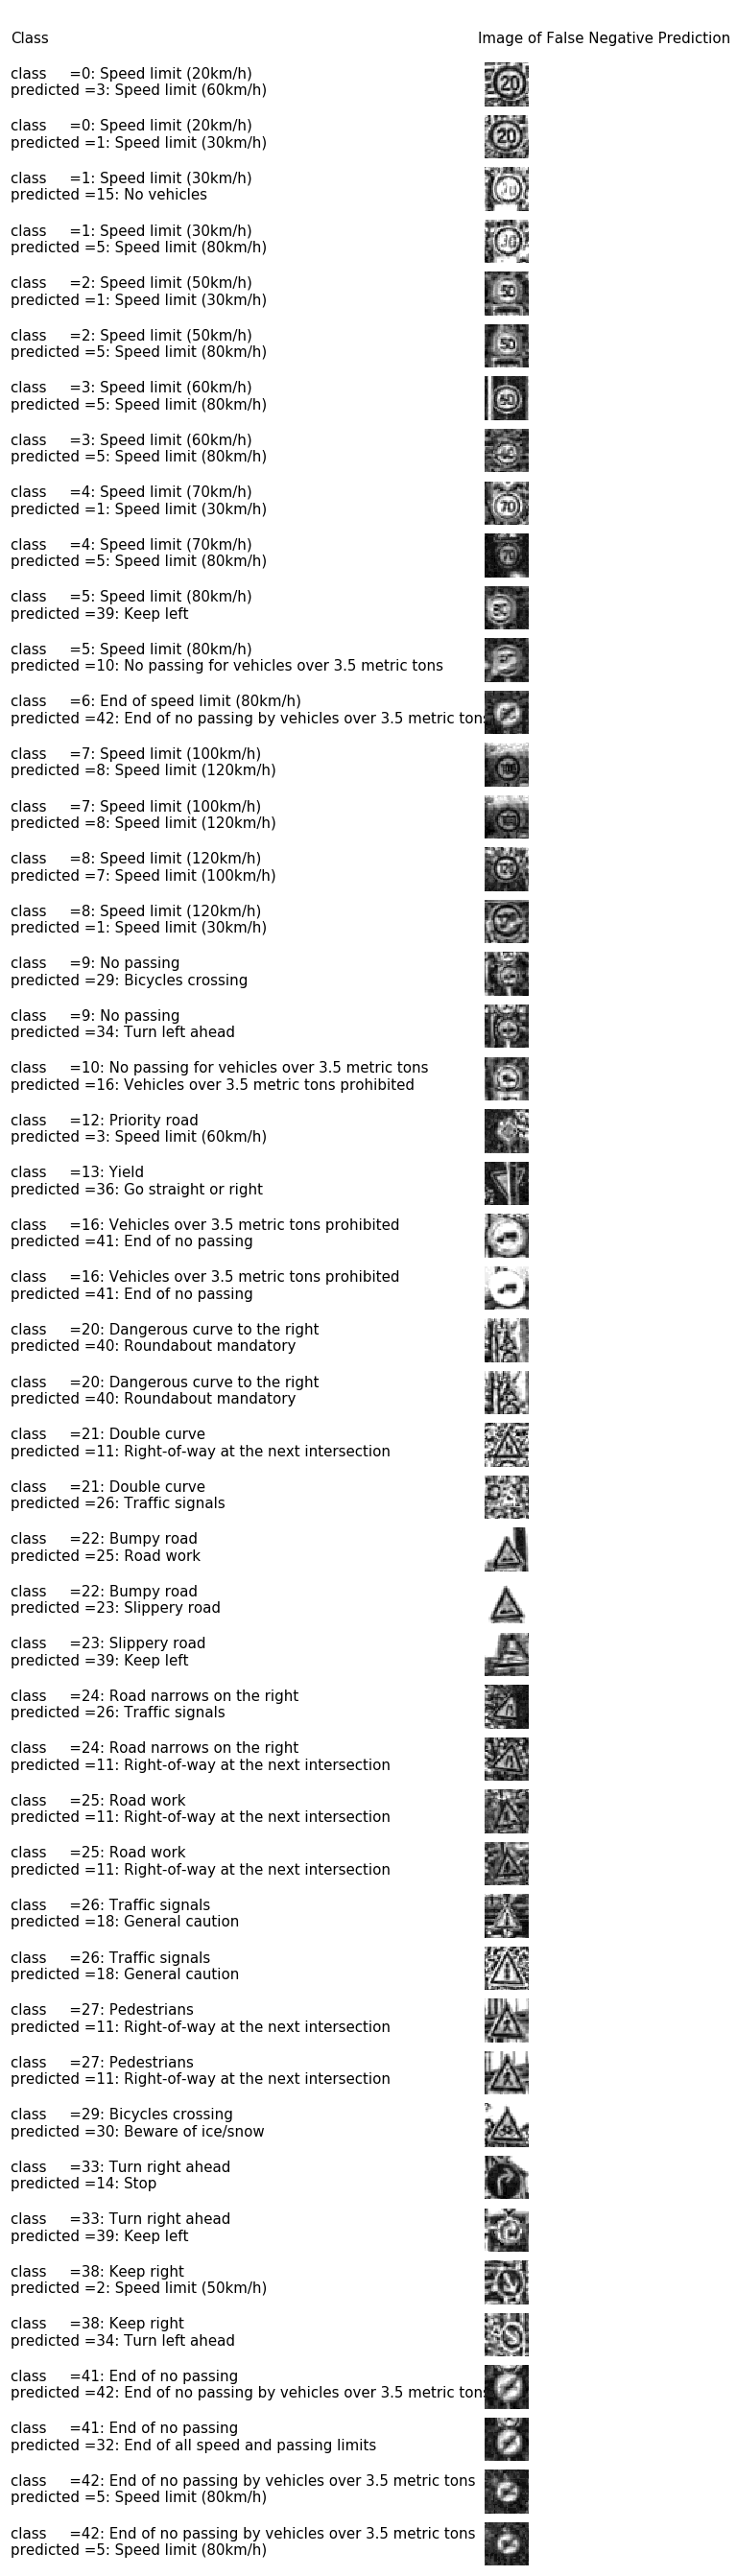

In [30]:
"""
Summary of validation accuracies & predictions
"""
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    print ('Validation accuracy and summary of predictions')
    accuracy = evaluate(X_valid, y_valid)
    print("Validation Accuracy = {:.3f}".format(accuracy))
    predictions = sess.run(tf.argmax(logits, 1), 
                           feed_dict={x_input:X_valid, keep_prob:1.0})
    summarize_predictions(X_valid, y_valid, predictions, filename=None)

---
## Once satisfied with training & validation, run on test set

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.942
Prediction summary: 
label                                                          count    true-pos   false-neg false-pos
class =0: Speed limit (20km/h)                                    60    60(100%)     0(0  %)         6
class =1: Speed limit (30km/h)                                   720   709(98 %)    11(1  %)        48
class =2: Speed limit (50km/h)                                   750   719(95 %)    31(4  %)        17
class =3: Speed limit (60km/h)                                   450   407(90 %)    43(9  %)        15
class =4: Speed limit (70km/h)                                   660   628(95 %)    32(4  %)        14
class =5: Speed limit (80km/h)                                   630   588(93 %)    42(6  %)       119
class =6: End of speed limit (80km/h)                            150   117(78 %)    33(22 %)         5
class =7: Speed limit (100km/h)                                  450   427(94 %)   

100%|██████████| 12630/12630 [00:00<00:00, 134128.52it/s]


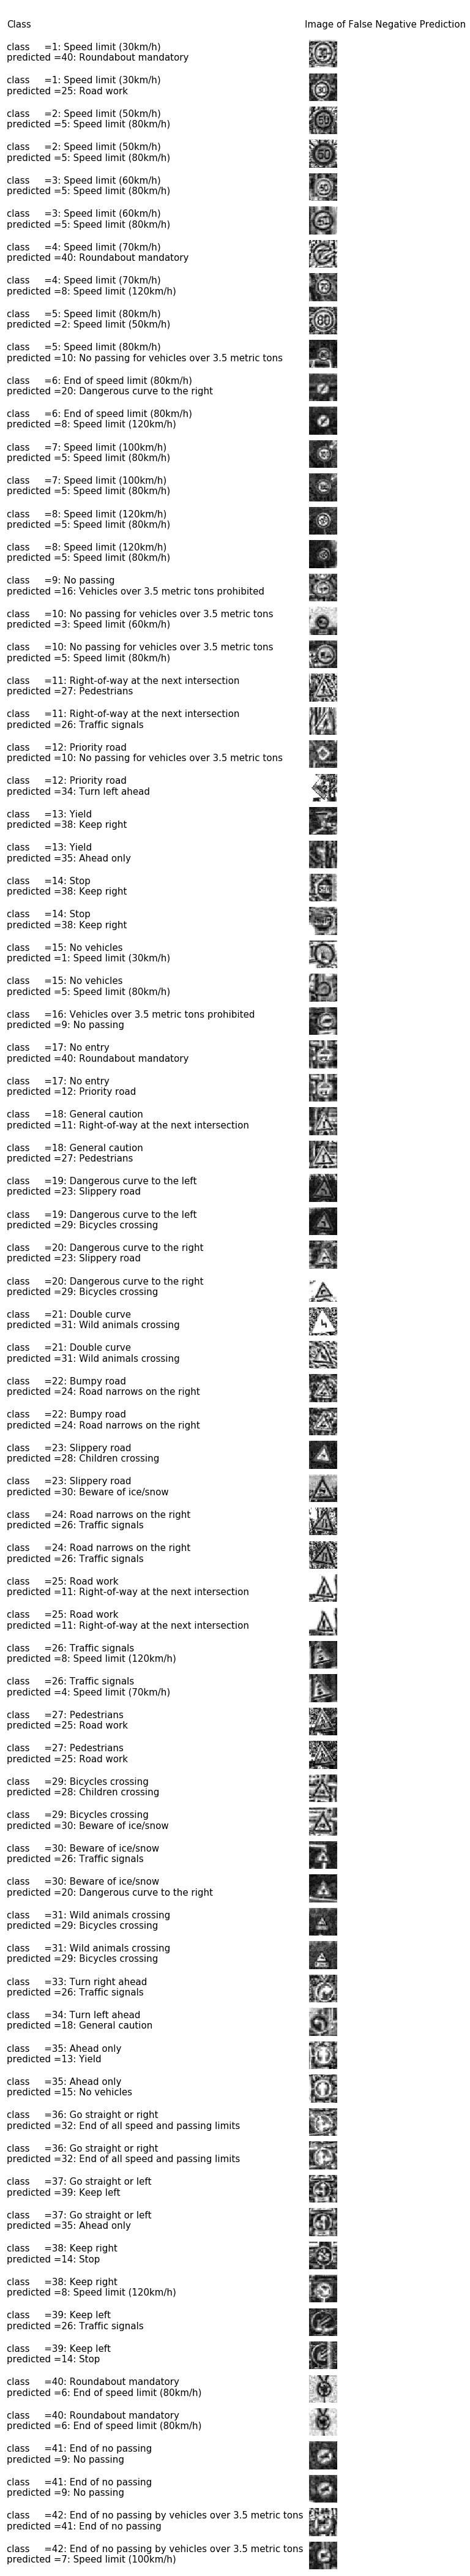

In [31]:
"""
Test the trained model on the test data
"""
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(accuracy))
    
    predictions = sess.run(tf.argmax(logits, 1), 
                               feed_dict={x_input:X_test, keep_prob:1.0})
    summarize_predictions(X_test, y_test, predictions, filename=None)

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

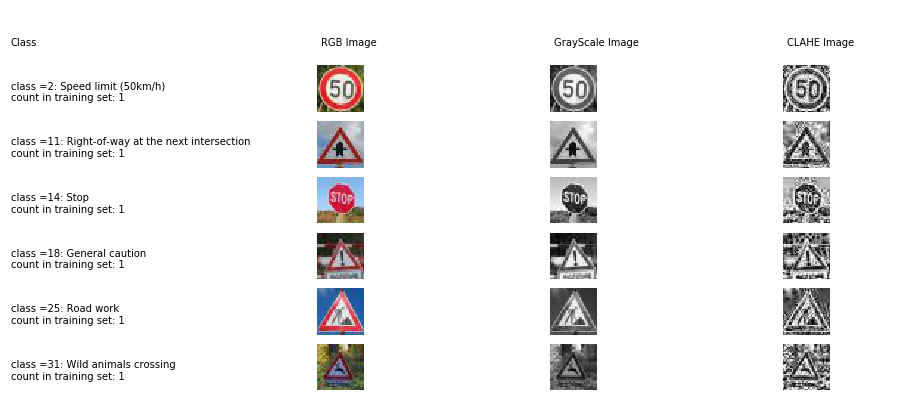

In [32]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
"""
Prepared 6 images of 32x32 pixels.
Read, pre-process and plot the images in RGB, grayscale and CLAHE.
"""
new_image_files = ['./data_new_signs/class2.jpg',
                   './data_new_signs/class11.jpg',
                   './data_new_signs/class14.jpg',
                   './data_new_signs/class18.jpg',
                   './data_new_signs/class25.jpg',
                   './data_new_signs/class31.jpg']

y_new = np.array([2, 11, 14, 18, 25, 31])

X_new = None
for image_file in new_image_files:
    new_image = mpimg.imread(image_file)
    if X_new is None:
        X_new = new_image.reshape(1,32,32,3)
    else:
        X_new = np.append(X_new, new_image.reshape(1,32,32,3), axis=0)
        
        

plot_image_and_effects_of_grayscale_and_clahe(X_new,y_new,
                                              filename=None)
                   

### Predict the Sign Type for Each Image

100%|██████████| 6/6 [00:00<00:00, 85.64it/s]

Applying GrayScale & CLAHE to each image in new data set
INFO:tensorflow:Restoring parameters from ./lenet



100%|██████████| 6/6 [00:00<00:00, 2209.08it/s]

New Images Prediction Accuracy = 0.667
Prediction summary: 
label                                                          count    true-pos   false-neg false-pos
class =2: Speed limit (50km/h)                                     1     0(0  %)     1(100%)         0
class =11: Right-of-way at the next intersection                   1     1(100%)     0(0  %)         0
class =14: Stop                                                    1     0(0  %)     1(100%)         0
class =18: General caution                                         1     1(100%)     0(0  %)         0
class =25: Road work                                               1     1(100%)     0(0  %)         0
class =31: Wild animals crossing                                   1     1(100%)     0(0  %)         0
------------------------------------------------------------------------------------------------------
TOTAL                                                              6           4           2         0
Plotting some

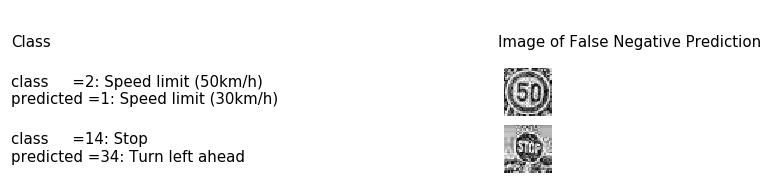

In [33]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
"""
Store all 6 images in new data set.
Test & summarize predictions.
"""

print('Applying GrayScale & CLAHE to each image in new data set')
X_new  = np.array([grayscale_and_clahe(X) for X in tqdm(X_new)]).reshape(
            len(X_new),32,32,1)


with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
 
    accuracy = evaluate(X_new, y_new)
    print("New Images Prediction Accuracy = {:.3f}".format(accuracy))
      
    sess = tf.get_default_session()
    predictions = sess.run(tf.argmax(logits, 1), 
                  feed_dict={x_input:X_new, keep_prob:1.0})

    summarize_predictions(X_new, y_new, predictions,
                          filename=None)


### Analyze Performance

In [34]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
"""
Analysis of performance already done in previous cell.
Here just give the accuracy in %-age
"""
print ('New images predicted with '+str(accuracy*100)+'% accuracy')

New images predicted with 66.66666865348816% accuracy


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

INFO:tensorflow:Restoring parameters from ./lenet
Top 5 softmax probabilities
--------------------------------------------------------------------------------
class =2: Speed limit (50km/h)
Predictions   :['         1', '         2', '         3', '         5', '        11']
Probabilities :['   100.00%', '     0.00%', '     0.00%', '     0.00%', '     0.00%']


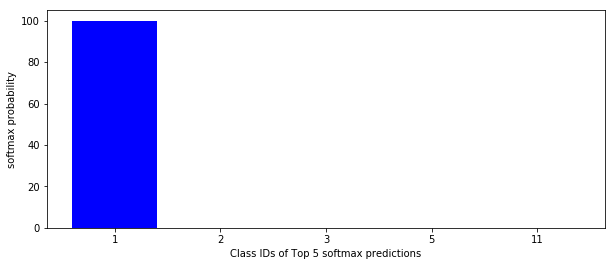

--------------------------------------------------------------------------------
class =11: Right-of-way at the next intersection
Predictions   :['        11', '        30', '        25', '        34', '        23']
Probabilities :['   100.00%', '     0.00%', '     0.00%', '     0.00%', '     0.00%']


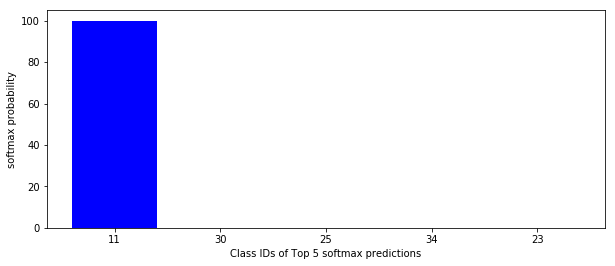

--------------------------------------------------------------------------------
class =14: Stop
Predictions   :['        34', '        14', '         3', '        38', '         1']
Probabilities :['    99.64%', '     0.25%', '     0.06%', '     0.03%', '     0.01%']


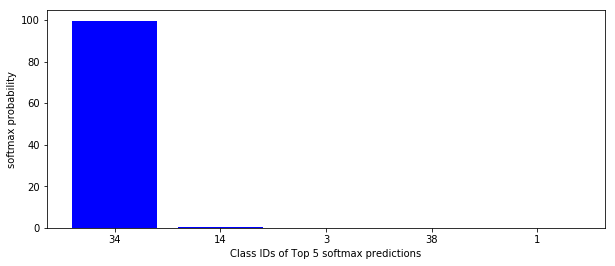

--------------------------------------------------------------------------------
class =18: General caution
Predictions   :['        18', '        26', '        27', '        11', '        37']
Probabilities :['   100.00%', '     0.00%', '     0.00%', '     0.00%', '     0.00%']


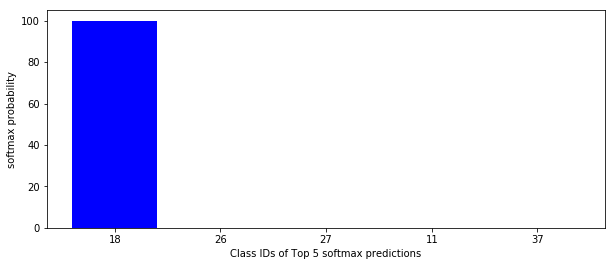

--------------------------------------------------------------------------------
class =25: Road work
Predictions   :['        25', '        28', '        20', '        23', '        22']
Probabilities :['   100.00%', '     0.00%', '     0.00%', '     0.00%', '     0.00%']


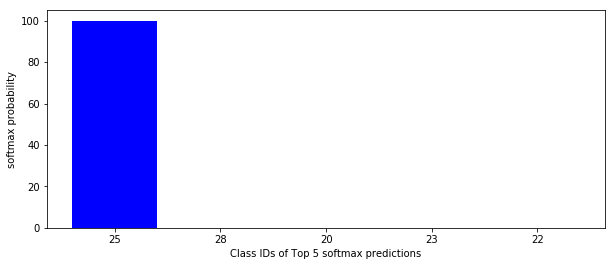

--------------------------------------------------------------------------------
class =31: Wild animals crossing
Predictions   :['        31', '        29', '        25', '        23', '         3']
Probabilities :['    99.99%', '     0.01%', '     0.00%', '     0.00%', '     0.00%']


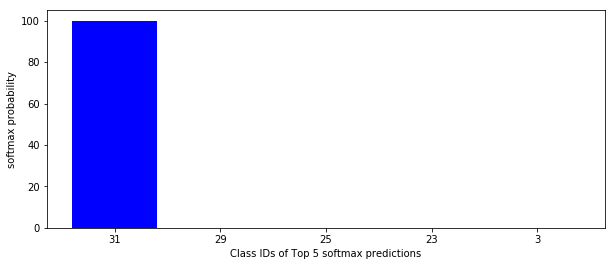

In [35]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
"""
For each new image, print the top five softmax probabilities.
This shows how certain the prediction is.
"""

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    sess = tf.get_default_session()
    
    softmax = sess.run(tf.nn.softmax(logits), 
                  feed_dict={x_input:X_new, keep_prob:1.0})
    
    TopKV2  = sess.run(tf.nn.top_k(softmax, k=5), 
                      feed_dict={x_input:X_new, keep_prob:1.0})
    

summarize_top_probabilities(y_new, TopKV2)


---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


INFO:tensorflow:Restoring parameters from ./lenet
Visualizing layer: conv1


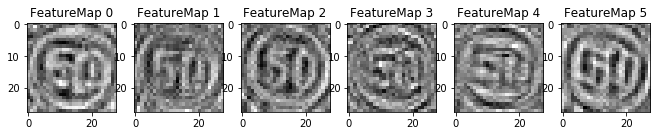

Visualizing layer: conv2


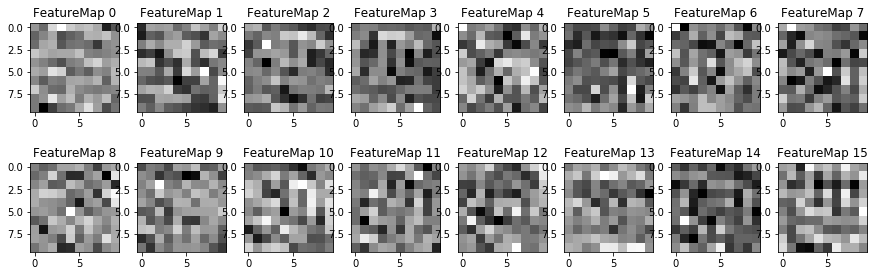

In [36]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a 
# specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x_input : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
            

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    sess.run(tf.global_variables_initializer())
    
    print('Visualizing layer: conv1')
    tf_conv1 = sess.run(conv1, feed_dict={x_input: X_new})
    outputFeatureMap(X_new, conv1)  # 6 FeatureMaps
    plt.show()
    
    print('Visualizing layer: conv2')
    tf_conv2 = sess.run(conv2, feed_dict={x_input: X_new})
    outputFeatureMap(X_new, conv2)  # 16 FeatureMaps
    plt.show()
    
    # the outputFeatureMap function is not valid for fc1, fc2 and logits. 
    # they do not have correct shape...
    



### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

I need to spend more time experimenting with this capability. I got the code running, and can see how for each layer (conv1, conv2) it plots the images for the outputs (6 featureMaps for conv1, and 16 featureMaps for conv2). It is clear from the images that the first layer (conv1) still resembles the actual image quite closely, but that the 2nd layer (conv2) starts to pixalate things much rougher, and it becomes difficult to visually interpret it.


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 